## *Required Libraries*

In [4]:
from keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.applications import DenseNet121
from keras.layers import Input,Rescaling,Resizing,Flatten,Dense
from keras.models import Sequential
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
import numpy as np
from keras.models import save_model,load_model
from keras.preprocessing.image import load_img,img_to_array

## *Loading Our Dataset*

*Training Dataset*

In [5]:
train_ds=image_dataset_from_directory('Dataset/train/Potato',
                                      batch_size=32,
                                      image_size=(256,256),
                                      shuffle=True)

Found 5702 files belonging to 3 classes.


*Valiation Dataset*

In [6]:
val_ds=image_dataset_from_directory('Dataset/valid/Potato',
                                      batch_size=32,
                                      image_size=(256,256),
                                      shuffle=True)

Found 1426 files belonging to 3 classes.


In [7]:
classes=train_ds.class_names
classes

['Early Blight', 'Healthy', 'Late Blight']

In [8]:
training_class=train_ds.class_names
training_class

['Early Blight', 'Healthy', 'Late Blight']

In [9]:
validation_class=val_ds.class_names
validation_class

['Early Blight', 'Healthy', 'Late Blight']

In [10]:
print(len(train_ds))
print(len(val_ds))

179
45


In [11]:
for img,label in train_ds.take(1):
    print(img.shape)
    print(label.numpy())

(32, 256, 256, 3)
[0 0 2 1 2 1 2 2 1 0 2 1 1 1 1 2 2 1 0 1 2 2 2 2 1 2 1 0 2 0 0 1]


## *Visualizing Some Images*

*Training Images*

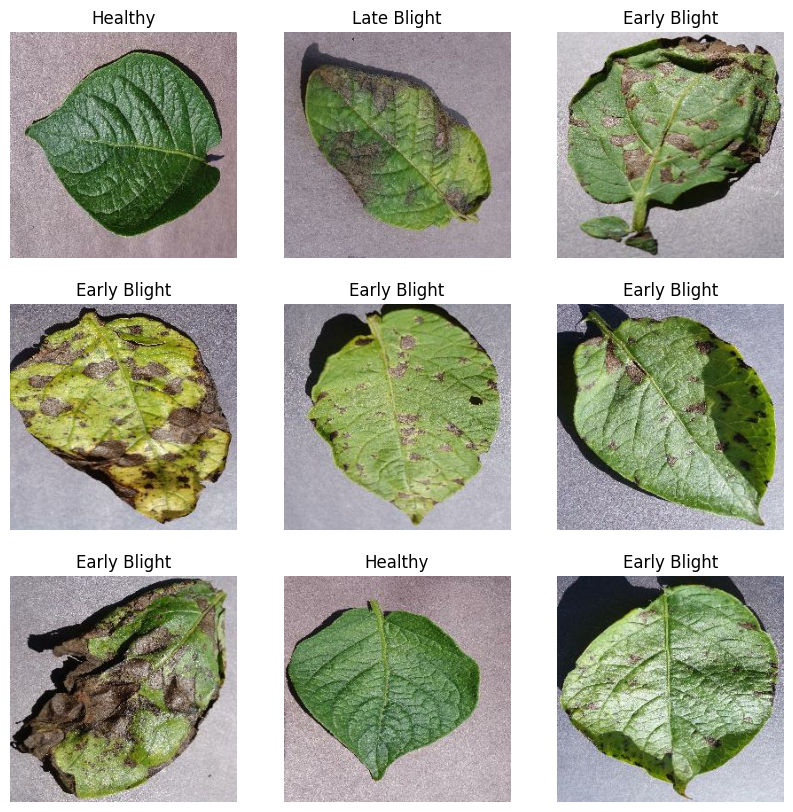

In [12]:
plt.figure(figsize=(10,10))
for image,label in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(training_class[label[i]])

*Validation Images*

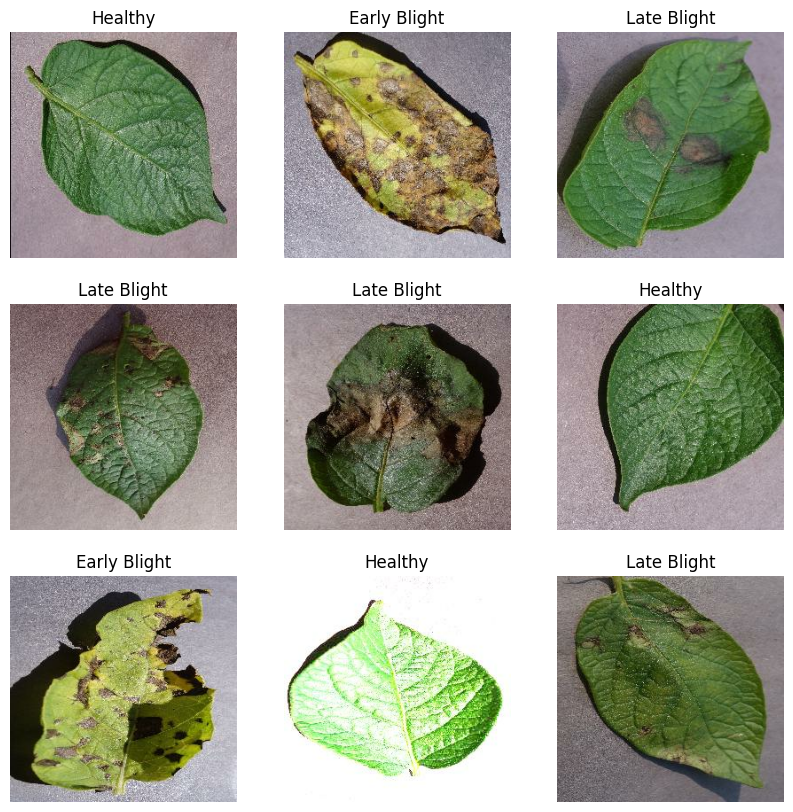

In [13]:
plt.figure(figsize=(10,10))
for image,label in val_ds.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(validation_class[label[i]])

In [14]:
# This will help to train our model quicker
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## *Building Our Model*

In [15]:
# Loading pre-trained DenseNet121 model (without including the top classification layers)
base_model=DenseNet121(include_top=False,input_shape=(256,256,3))

In [16]:
base_model.trainable=False # Freezing the layers of the base model

In [17]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 262, 262, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 128, 128, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1/conv[0][0]']

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.78911 to fit



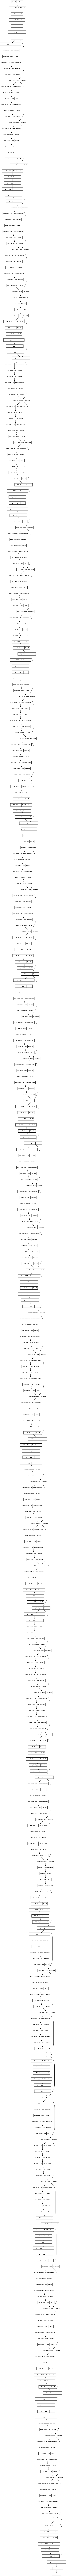

In [18]:
plot_model(base_model)

*Creating a rescaling and resizing layer*

In [19]:
rescaling_layer=Rescaling(1.0/255) # Adding a rescaling layer to scale pixel values to the range [0, 1]

resizing_layer=Resizing(256,256) # Add a resizing layer to resize images to (256, 256)

*Adding Dense Layer*

In [20]:
model=Sequential()
model.add(Input(shape=(256,256,3)))
model.add(resizing_layer)
model.add(rescaling_layer)
model.add(base_model)
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(len(classes), activation='softmax'))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 256, 256, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 64)                4194368   
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 11232067 (42.85 MB)
Trainable params: 4194

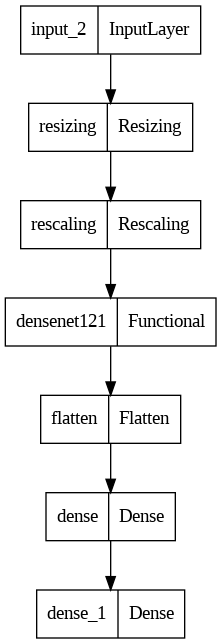

In [22]:
plot_model(model)

## *Model Compilation*

In [23]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

## *Using Early Stopping*

In [24]:
early_stopping=EarlyStopping(monitor='val_loss',patience=3)

## *Model Training*

In [25]:
history=model.fit(train_ds,epochs=50,batch_size=32,validation_data=val_ds,callbacks=[early_stopping])

Epoch 1/50
179/179 [==============================] - 69s 259ms/step - loss: 1.0409 - accuracy: 0.9093 - val_loss: 0.0259 - val_accuracy: 0.9909
Epoch 2/50
179/179 [==============================] - 26s 145ms/step - loss: 0.0284 - accuracy: 0.9898 - val_loss: 0.1642 - val_accuracy: 0.9565
Epoch 3/50
179/179 [==============================] - 27s 151ms/step - loss: 0.0361 - accuracy: 0.9888 - val_loss: 0.0132 - val_accuracy: 0.9958
Epoch 4/50
179/179 [==============================] - 27s 149ms/step - loss: 0.0042 - accuracy: 0.9991 - val_loss: 0.0146 - val_accuracy: 0.9958
Epoch 5/50
179/179 [==============================] - 27s 148ms/step - loss: 0.0094 - accuracy: 0.9972 - val_loss: 0.0556 - val_accuracy: 0.9846
Epoch 6/50
179/179 [==============================] - 27s 151ms/step - loss: 0.0052 - accuracy: 0.9986 - val_loss: 0.0141 - val_accuracy: 0.9937


## *Model Evaluation*

In [26]:
loss, accuracy = model.evaluate(val_ds,verbose=0)
print("Accuracy",accuracy)
print("Loss",loss)

Accuracy 0.9936886429786682
Loss 0.014075365848839283


## *Visualizing Accuracy and Loss*

In [27]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

In [28]:
epochs_completed = len(history.history['loss'])
epochs_completed

6

*Training Accuracy vs Validation Accuracy*

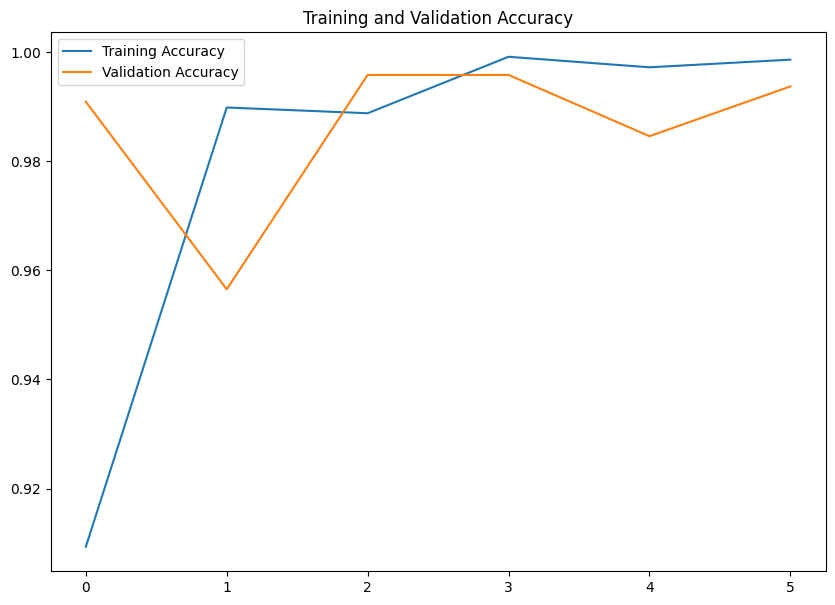

In [29]:
plt.figure(figsize=(10,7))
plt.plot(range(epochs_completed),acc,label='Training Accuracy')
plt.plot(range(epochs_completed),val_acc,label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

*Training Loss vs Validation Loss*

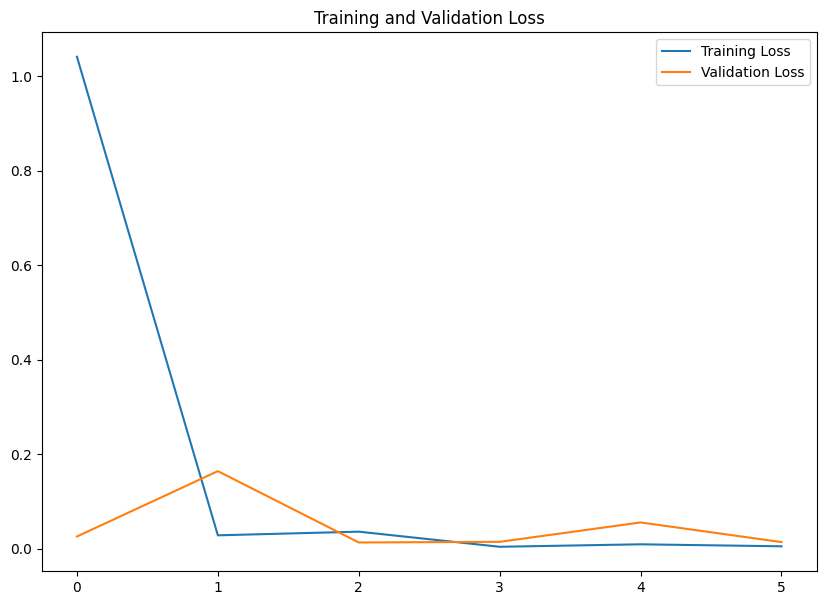

In [30]:
plt.figure(figsize=(10,7))
plt.plot(range(epochs_completed),loss,label='Training Loss')
plt.plot(range(epochs_completed),val_loss,label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

## *Saving Our Model*

In [ ]:
save_model(model,'potato_model.h5')

## *Loading Our Model*

In [32]:
model=load_model('potato_model.h5')

## *Model Testing*

Early Blight


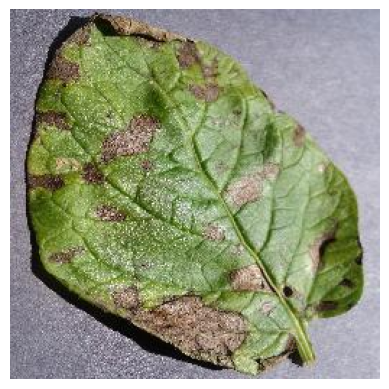

In [34]:
image=load_img('/content/PotatoEarlyBlight1.JPG')
image_array=img_to_array(image)
expanded_image=np.expand_dims(image_array,axis=0)

pred=model.predict(expanded_image,verbose=0)
result=classes[np.argmax(pred[0])]
print(result)
plt.imshow(image)
plt.axis('off')
plt.show()